In [1]:
import sys
sys.path.append('..')
from pyurb.urb_kitti import *
import numpy as np
import cv2
%matplotlib inline

Read frame transformations from KITTI sequence 00 into a list of frames (frame).

In [2]:
IMAGE_SIZE = 400

def load(file):
    keyframeids, frameids, poses = load_keyframes(file)
    return keyframeids, frameids, poses.reshape(poses.shape[0], 4, 4)

def load_csv(file):
    poses = np.genfromtxt(file, delimiter= " ")
    poses = np.hstack([poses, np.repeat(np.array([[0,0,0,1.0]]), len(poses), axis=0) ])
    return poses.reshape(poses.shape[0], 4, 4)

def transform(poses):
    points = np.repeat(np.array([[0,0,0,1.0]]), len(poses), axis=0) 
    for i in range(1, len(poses)):
        points[:i] = np.dot(points[:i], poses[i].T)
    return points
        
def transform2(poses):
    points = poses[:,:,3]
    return points
    
def plot_trajectory(points):
    # remove y coordinate (we only use x and z to plot a view from above)
    points = points[:, [0,2,3]]
    # compute min and max
    pmin = points.min(axis=0)
    pmax = points.max(axis=0)
    maxxy = max(pmax[0] - pmin[0], pmax[1] - pmin[1])

    t = np.eye(3, dtype=np.float64)
    t[0,0] = IMAGE_SIZE / maxxy
    t[1,1] = -IMAGE_SIZE / maxxy
    t[0,2] = -pmin[0] * IMAGE_SIZE / maxxy
    t[1,2] = IMAGE_SIZE / maxxy + pmin[1] / maxxy + 100

    return np.dot(points, t.T)
    

def plot_trajectory2(points):
    # remove y coordinate (we only use x and z to plot a view from above)
    points = points[:, [0,2,3]]
    # compute min and max
    pmin = points.min(axis=0)
    pmax = points.max(axis=0)
    maxxy = max(pmax[0] - pmin[0], pmax[1] - pmin[1]) * 1.01

    t = np.eye(3, dtype=np.float64)
    t[0,0] = IMAGE_SIZE / maxxy
    t[1,1] = -IMAGE_SIZE / maxxy
    t[0,2] = -pmin[0] * IMAGE_SIZE / maxxy
    t[1,2] = IMAGE_SIZE / maxxy + pmin[1] / maxxy + 100
    return np.dot(points, t.T)
    
def plot_trajectory3(points):
    coords = []
    minx = min([p[0] for p in points])
    maxx = max([p[0] for p in points])
    miny = min([p[2] for p in points])
    maxy = max([p[2] for p in points])
    maxxy = max(maxx - minx, maxy - miny)* 1.01

    for p in points:
        #print(p)
        x = IMAGE_SIZE * (p[0] - minx) / (maxxy)
        z = IMAGE_SIZE - IMAGE_SIZE * (p[2] - miny) / (maxxy)
        coords.append([x, z])
    return coords

def new_image():
    img = np.zeros((IMAGE_SIZE, IMAGE_SIZE, 3), np.uint8)
    img[:] = 255 #or img.fill(255)
    return img

def draw(coords, img, color = (0,0,0)):
    # Draw a black line with thickness of 2 px
    for i in range(1,len(coords)):
        cv2.line(img, (int(coords[i - 1][0]), int(coords[i - 1][1])), (int(coords[i][0]), int(coords[i][1])), color, 2)
    return img

Compute the frame positions by mutiplying every point by a sequence of their transformations
vectorized to improve speed

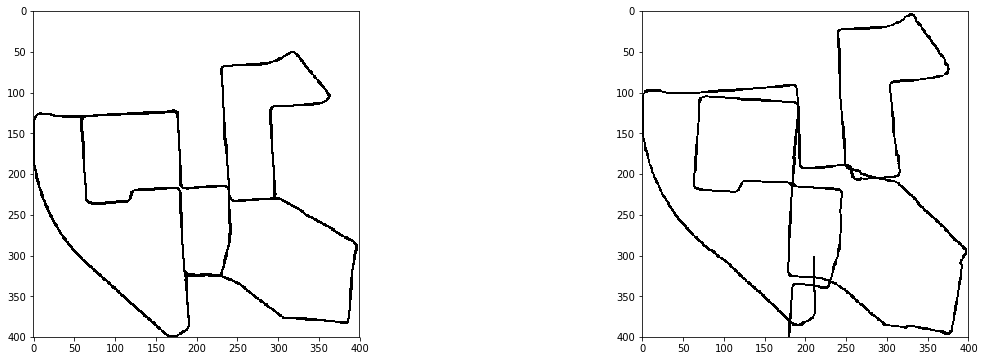

In [11]:
sequence = 0

# keyframeids, frameids, poses = load('/data/urbinn/datasets/urb_trajectory_output//keyframes_%02d_all_17_1.6_1.6.npy'%(sequence))
keyframeids, frameids, poses = load('/home/14077132/notebooks/pyurb/notebooks/cv_keyframes.npy')

# for keyframeid in keyframeids:
#     print(keyframeid)
# for frameid in frameids:
#     print(frameid)
# for pose in poses:
#     print(pose)
    
# print(len(keyframeids))

# print(len(frameids))
    
points = transform(poses)
coords = plot_trajectory3(points)
p = draw(coords, new_image())

gt = load_csv('/data/urbinn/datasets/kitti/poses/%02d.txt'%(sequence))
points_gt = transform2(gt)
coords_gt = plot_trajectory3(points_gt)
show2(draw(coords_gt, new_image()), p)

Show the affine world coodinates for the first 3 poses

In [4]:
v = points[0] - points[-1]
v2 = points_gt[0] - points_gt[-1]
v = v[[0,2, 3]]
v2 = v2[[0,2, 3]]
v, v2

import math
cosalpha  = np.dot(v, v2) / np.linalg.norm(v) / np.linalg.norm(v2)
sinalpha = math.cos(math.pi/2 - math.acos(cosalpha))
print(cosalpha, sinalpha)
points_new = points - points[0]
t = np.eye(4, dtype=np.float64)
t[0,0] = cosalpha
t[2,2] = cosalpha
t[0,2] = sinalpha
t[2,0] = -sinalpha
points_new = np.dot(points_new, t.T)
points_new = points_new + points_gt[0]

0.935089165535 0.35441254562939645


show the converted x,y coordinates to plot the trajectory

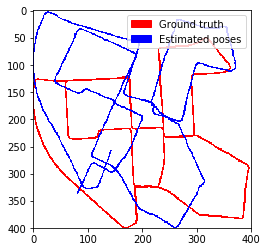

In [5]:
coords = plot_trajectory3(points_new)
p = draw(coords, new_image())
img = draw(coords_gt, new_image(),(255,0,0))
# show(draw(coords, img,(0,0,255)))

show_with_label(draw(coords, img,(0,0,255)), "red", "blue", "Ground truth", "Estimated poses")

In [52]:
import json

# Paths
yolo_path = "/data/urbinn/darknet/output/seq00_image02/objects.json"
keyframeids, frameids, poses = load('/home/14077132/notebooks/pyurb/notebooks/cv_keyframes_seq00.npy')

# Open Json
try:
    with open(yolo_path) as results:
        results = json.loads(results.read())
        N = len(results)
except:
    print("Invalid/empty Json file")

# Loop frameids
for idx, val in enumerate(frameids):
    urb_keyframe_id = int(frameids[idx])
    # Loop Yolo objects
    for i, obj in enumerate(results):
        yolo_frame_id = int(obj[0].replace('.png', ''))
        # Match Yolo_frameids to Urb_keyframeids
        if yolo_frame_id == urb_keyframe_id:
            for n, match in enumerate(obj):
                # TODO - here points with tooltip labels
                print(obj[n])
                print("\n")
            break
        

000000.png


['Car', 0.5439351201057434, [603.5936279296875, 195.56185913085938, 19.112337112426758, 31.28185272216797]]


['Window', 0.49518996477127075, [1069.3404541015625, 118.05902099609375, 63.93918991088867, 79.4073486328125]]


000007.png


['Window', 0.6420016884803772, [250.89576721191406, 174.16104125976562, 22.05120849609375, 65.09669494628906]]


['Window', 0.6119444966316223, [1107.6707763671875, 53.31854248046875, 31.82358741760254, 47.52534484863281]]


['Window', 0.5283887982368469, [198.38160705566406, 175.65762329101562, 33.556434631347656, 57.046878814697266]]


['Car', 0.5204149484634399, [627.4060668945312, 197.72373962402344, 21.343137741088867, 25.578250885009766]]


['Window', 0.42119988799095154, [734.1100463867188, 127.0650634765625, 15.859387397766113, 40.15761184692383]]


000013.png


['Car', 0.6585469841957092, [671.439453125, 212.6696319580078, 34.5367317199707, 34.692481994628906]]


['Window', 0.4674220383167267, [84.75653076171875, 43.19483184814453, 

['Window', 0.42381197214126587, [42.47563171386719, 87.69767761230469, 62.4792594909668, 77.48097229003906]]


['Window', 0.42111077904701233, [317.26873779296875, 39.2717170715332, 64.26884460449219, 55.1981086730957]]


000849.png


['Car', 0.48403194546699524, [605.4988403320312, 214.26409912109375, 26.279949188232422, 27.2260799407959]]


['Window', 0.46045956015586853, [899.2659912109375, 178.73785400390625, 23.38248634338379, 34.13355255126953]]


000854.png


['Car', 0.6886101961135864, [624.1185913085938, 208.82095336914062, 29.277912139892578, 28.264944076538086]]


['Window', 0.6689873933792114, [149.79116821289062, 126.0184555053711, 96.23954010009766, 150.97793579101562]]


['Car', 0.6317058801651001, [777.8975830078125, 244.60655212402344, 102.04979705810547, 94.37295532226562]]


['Car', 0.5097580552101135, [700.7709350585938, 207.03909301757812, 23.358657836914062, 25.087047576904297]]


['Car', 0.49633750319480896, [612.1168212890625, 209.471435546875, 28.05408668518066

['Car', 0.5806697010993958, [575.916748046875, 196.02186584472656, 24.110212326049805, 23.595609664916992]]


['Window', 0.5797749161720276, [936.9995727539062, 43.227237701416016, 25.49738883972168, 62.58490753173828]]


['Car', 0.5739706754684448, [673.69287109375, 199.87477111816406, 25.75710105895996, 24.085956573486328]]


['Car', 0.501020073890686, [442.7254333496094, 228.6228485107422, 75.53236389160156, 60.10146713256836]]


['Window', 0.45114293694496155, [901.4639892578125, 149.42222595214844, 15.186101913452148, 34.65757751464844]]


['Window', 0.4128047823905945, [344.1780090332031, 82.64754486083984, 20.825773239135742, 64.10595703125]]


001469.png


['Window', 0.8345465064048767, [311.59234619140625, 161.31529235839844, 22.936359405517578, 54.029273986816406]]


['Window', 0.8104196190834045, [344.8682861328125, 161.07041931152344, 19.015718460083008, 60.399070739746094]]


['Car', 0.7797493934631348, [703.8434448242188, 199.47201538085938, 35.76665115356445, 35.36326599



001922.png


['Lamppost', 0.4748205244541168, [514.948974609375, 120.76797485351562, 14.772638320922852, 164.90841674804688]]


['Window', 0.4409163296222687, [739.2603759765625, 145.5298309326172, 25.85268211364746, 39.57744216918945]]


001924.png


['Window', 0.47931161522865295, [733.3679809570312, 150.1012725830078, 24.78154182434082, 35.78422546386719]]


['Window', 0.4031378924846649, [1131.7943115234375, 84.25431060791016, 30.582937240600586, 43.73405456542969]]


001928.png


['Window', 0.7203190326690674, [703.0881958007812, 145.43743896484375, 24.473167419433594, 42.24658966064453]]


001936.png


['Car', 0.47516587376594543, [1032.8431396484375, 255.09356689453125, 286.7845153808594, 124.01380157470703]]


['Window', 0.40181779861450195, [1002.4329223632812, 37.983638763427734, 23.247642517089844, 35.79005813598633]]


001941.png


['Window', 0.46405228972435, [22.841838836669922, 91.30415344238281, 40.40907669067383, 56.31187438964844]]


['Car', 0.4556794762611389, [77.

['Window', 0.43086668848991394, [729.3866577148438, 146.2037811279297, 73.42488861083984, 93.08635711669922]]


002433.png


['Car', 0.7821863889694214, [973.5772705078125, 232.3895263671875, 154.04981994628906, 80.22366333007812]]


['Window', 0.6351851224899292, [1076.9332275390625, 145.6667938232422, 49.19628143310547, 53.19528579711914]]


['Window', 0.568118691444397, [837.8569946289062, 27.041057586669922, 46.386985778808594, 36.43170928955078]]


['Window', 0.5645737051963806, [1163.716552734375, 146.54420471191406, 15.978509902954102, 35.11477279663086]]


['Window', 0.5294704437255859, [930.9408569335938, 26.16351890563965, 34.58821487426758, 28.969953536987305]]


['Window', 0.5024246573448181, [1203.5576171875, 87.74385833740234, 22.44171714782715, 43.14656066894531]]


['Window', 0.47274306416511536, [1164.3756103515625, 80.37602233886719, 18.902528762817383, 41.47280502319336]]


['Window', 0.4637186527252197, [984.1980590820312, 112.68962860107422, 42.699119567871094, 56.

002751.png


['Car', 0.7430112957954407, [466.22491455078125, 245.14810180664062, 108.98760223388672, 95.34931945800781]]


['Window', 0.5975104570388794, [896.8859252929688, 21.388202667236328, 36.67814636230469, 35.01422882080078]]


['Car', 0.44082072377204895, [667.0902709960938, 209.21910095214844, 22.357091903686523, 43.812923431396484]]


002752.png


['Car', 0.6164025068283081, [667.1331787109375, 210.86888122558594, 25.00910186767578, 44.04088592529297]]


['Car', 0.5824003219604492, [449.37127685546875, 250.23207092285156, 124.10357666015625, 103.38776397705078]]


['Car', 0.4390314519405365, [696.011474609375, 218.86300659179688, 37.64897918701172, 68.99028015136719]]


['Car', 0.42403697967529297, [637.5665283203125, 207.9617156982422, 26.972349166870117, 35.37944412231445]]


['Car', 0.4054693877696991, [540.3182373046875, 207.60223388671875, 40.2967529296875, 34.40141296386719]]


002754.png


['Car', 0.7507683634757996, [666.2420043945312, 210.6352996826172, 27.581661224



['Car', 0.7245272397994995, [580.4235229492188, 194.04051208496094, 24.399465560913086, 26.02523422241211]]


['Window', 0.6748049855232239, [931.3859252929688, 39.73240280151367, 23.78336524963379, 57.60270309448242]]


['Car', 0.6673824787139893, [664.79150390625, 201.10702514648438, 25.854188919067383, 31.287261962890625]]


['Window', 0.5578415989875793, [955.0139770507812, 137.88421630859375, 48.036563873291016, 76.8954849243164]]


['Window', 0.5024102926254272, [872.0217895507812, 38.91619110107422, 23.635448455810547, 39.97828674316406]]


['Car', 0.5024051070213318, [743.3897705078125, 228.7969207763672, 108.150146484375, 82.46209716796875]]


['Window', 0.4770124554634094, [439.9828796386719, 54.04783630371094, 16.67661476135254, 43.70608901977539]]


['Window', 0.4712669551372528, [961.1828002929688, 37.85316848754883, 25.564119338989258, 58.78165054321289]]


['Car', 0.4642343521118164, [640.8801879882812, 190.6377410888672, 16.908578872680664, 20.421167373657227]]


['Wi



003267.png


['Window', 0.7319308519363403, [598.6165771484375, 127.00987243652344, 67.95706939697266, 106.75639343261719]]


['Window', 0.6719223856925964, [108.75047302246094, 131.99923706054688, 47.494083404541016, 86.78485870361328]]


['Window', 0.5557234287261963, [217.5279998779297, 133.04248046875, 50.918357849121094, 85.8214340209961]]


['Window', 0.5319300889968872, [213.72911071777344, 25.336105346679688, 37.13084411621094, 33.62675094604492]]


['Window', 0.4899125099182129, [110.0751724243164, 31.102031707763672, 32.33205795288086, 41.851280212402344]]


['Window', 0.48664841055870056, [469.40557861328125, 125.75691986083984, 64.70313262939453, 104.80453491210938]]


['Window', 0.4839344322681427, [706.5431518554688, 63.157169342041016, 74.95555877685547, 89.29177856445312]]


['Window', 0.43313083052635193, [1083.62646484375, 40.819854736328125, 54.95588684082031, 44.7485237121582]]


003268.png


['Window', 0.7810894846916199, [568.3580322265625, 128.35423278808594, 7

['Car', 0.7747392058372498, [570.343994140625, 198.04995727539062, 55.170352935791016, 47.349891662597656]]


['Car', 0.6310185194015503, [668.5407104492188, 196.13525390625, 32.25074768066406, 34.837406158447266]]


['Window', 0.5122072696685791, [1031.3592529296875, 54.95295715332031, 60.76952362060547, 67.94612121582031]]


['Window', 0.4942900538444519, [1155.537841796875, 59.70332717895508, 41.89186096191406, 50.015708923339844]]


['Window', 0.44020387530326843, [475.4580993652344, 81.62947082519531, 17.040193557739258, 29.804826736450195]]


003519.png


['Window', 0.66642165184021, [212.93814086914062, 21.819835662841797, 31.567182540893555, 31.332311630249023]]


['Car', 0.6648303270339966, [628.1024780273438, 201.81224060058594, 40.303592681884766, 42.89297103881836]]


['Window', 0.55101478099823, [1037.6888427734375, 43.020416259765625, 80.11737823486328, 86.05329895019531]]


['Car', 0.5491541028022766, [519.5435180664062, 208.26675415039062, 80.13426971435547, 52.79829025



['Window', 0.7285552620887756, [404.78179931640625, 75.8004379272461, 35.32079315185547, 48.14363479614258]]


['Window', 0.7230249643325806, [896.1475219726562, 158.34812927246094, 32.10463333129883, 48.897064208984375]]


['Window', 0.6898505687713623, [220.57379150390625, 114.7448501586914, 53.38676071166992, 130.92022705078125]]


['Window', 0.6543492674827576, [104.29513549804688, 97.71581268310547, 62.211814880371094, 165.2289581298828]]


['Car', 0.6420189738273621, [658.5784912109375, 209.1675567626953, 49.33742904663086, 48.1456413269043]]


['Car', 0.5472665429115295, [561.8648681640625, 190.98716735839844, 25.907630920410156, 23.76933479309082]]


['Window', 0.49583548307418823, [794.0421142578125, 189.55487060546875, 27.07724380493164, 63.25362014770508]]


['Door', 0.44941446185112, [220.10244750976562, 121.14756774902344, 44.42409896850586, 119.57235717773438]]


['Window', 0.41913875937461853, [989.82861328125, 155.4292449951172, 27.710529327392578, 57.739837646484375]



004067.png


['Car', 0.8134894967079163, [494.82275390625, 207.71023559570312, 19.900997161865234, 24.87943458557129]]


['Window', 0.4136714041233063, [379.44952392578125, 88.39250183105469, 15.102046012878418, 38.735843658447266]]


004070.png


['Car', 0.8457728028297424, [501.24530029296875, 202.6797637939453, 24.686315536499023, 24.83637237548828]]


['Window', 0.42113038897514343, [375.0671691894531, 83.62760162353516, 14.20809268951416, 27.14822006225586]]


004073.png


['Car', 0.8457683324813843, [503.9582214355469, 203.01467895507812, 24.311115264892578, 24.91544532775879]]


['Car', 0.4409066140651703, [447.0198974609375, 200.0611572265625, 12.42694091796875, 16.26406478881836]]


004074.png


['Car', 0.8021613359451294, [502.683837890625, 203.91346740722656, 28.70537567138672, 25.002470016479492]]


['Car', 0.4786073863506317, [447.59033203125, 199.86004638671875, 13.370702743530273, 15.852941513061523]]


004076.png


['Car', 0.7089002728462219, [504.361328125, 203.98571


004236.png


['Car', 0.9197726249694824, [574.8325805664062, 198.48568725585938, 16.918352127075195, 18.398162841796875]]


004239.png


['Car', 0.9075927138328552, [574.7067260742188, 203.23291015625, 17.751190185546875, 21.96051788330078]]


004243.png


['Car', 0.9233656525611877, [577.9339599609375, 201.7772674560547, 20.016895294189453, 22.401660919189453]]


004249.png


['Car', 0.8898465633392334, [577.8739013671875, 199.42941284179688, 21.02369499206543, 21.683975219726562]]


004252.png


['Car', 0.8778866529464722, [577.4249267578125, 203.11349487304688, 22.64236831665039, 25.670225143432617]]


['Window', 0.49989157915115356, [178.81021118164062, 40.344818115234375, 36.870323181152344, 53.890323638916016]]


004254.png


['Car', 0.9226909279823303, [576.2369995117188, 201.94187927246094, 22.659618377685547, 24.68312644958496]]


004258.png


['Car', 0.870424211025238, [566.7025146484375, 207.3533172607422, 24.773340225219727, 23.74298667907715]]


['Window', 0.7291219234466



['Car', 0.6717174649238586, [665.9425659179688, 214.88014221191406, 31.336193084716797, 32.28076171875]]


['Car', 0.5263798236846924, [646.2151489257812, 209.3472137451172, 25.461776733398438, 27.511905670166016]]


['Car', 0.5188438892364502, [635.1657104492188, 200.02110290527344, 24.125150680541992, 26.666975021362305]]


['Car', 0.4201042354106903, [530.79541015625, 208.93995666503906, 25.312088012695312, 23.85783576965332]]


004473.png


['Car', 0.8358501195907593, [670.2472534179688, 211.6333770751953, 26.5606689453125, 30.330524444580078]]


['Car', 0.5204368233680725, [705.0130615234375, 222.31463623046875, 59.070152282714844, 49.48582077026367]]


['Car', 0.5180542469024658, [530.9200439453125, 209.85556030273438, 26.52569007873535, 22.54789924621582]]


['Car', 0.4532076120376587, [115.37774658203125, 286.8959045410156, 261.1879577636719, 132.35890197753906]]


['Window', 0.447618693113327, [1093.1527099609375, 107.67068481445312, 67.2730941772461, 132.93589782714844]]




In [10]:
import mpld3
import pandas as pd
from mpld3 import plugins

# Define some CSS to control our custom labels
css = """
table
{
  border-collapse: collapse;
}
th
{
  color: #ffffff;
  background-color: #000000;
}
td
{
  background-color: #cccccc;
}
table, th, td
{
  font-family:Arial, Helvetica, sans-serif;
  border: 1px solid black;
  text-align: right;
}
"""

fig, ax = plt.subplots()
ax.grid(True, alpha=0.3)

N = 50
df = pd.DataFrame(index=range(N))
df['x'] = np.random.randn(N)
df['y'] = np.random.randn(N)
df['z'] = np.random.randn(N)

labels = []
for i in range(N):
    label = df.loc[[i], :].T
    label.columns = ['Row {0}'.format(i)]
    # .to_html() is unicode; so make leading 'u' go away with str()
    labels.append(str(label.to_html()))

points = ax.plot(df.x, df.y, 'o', color='b',
                 mec='k', ms=15, mew=1, alpha=.6)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('HTML tooltips', size=20)

tooltip = plugins.PointHTMLTooltip(points[0], labels,
                                   voffset=10, hoffset=10, css=css)
plugins.connect(fig, tooltip)

mpld3.display()

[    0.     7.    13. ...,  4532.  4535.  4537.]


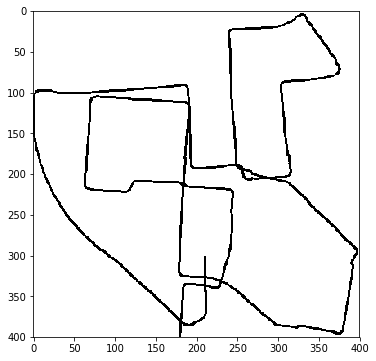

In [53]:
keyframeids, frameids, poses = load('/home/14077132/notebooks/pyurb/notebooks/cv_keyframes_seq00.npy')
print(frameids)
points = transform(poses)
coords = plot_trajectory3(points)
p = draw(coords, new_image())

show(p)